In [4]:
import pandas as pd
import numpy as np
import scanpy as sc
from collections import Counter

### 1. load and cell annotations

In [2]:
adata = sc.read("integrated_hepatoblastoma_v2.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 26886 × 33538 
    obs: 'n_genes', 'n_counts', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'Sample', 'Cell class', 'Cell class_v2', 'Tumor Cluster', 'count by Sample/Cell class/Tumor Cluster'
    obsm: 'X_umap'
    layers: 'norm_data'

In [17]:
map_values = {"background":"HBB", "human hepatoplastoma":"HBT", "pdx": "PDX"}
adata.obs["Sample_v2"] = [map_values[i] for i in adata.obs["Sample"]]
adata.obs["new_index"] = [i.split("-")[0] for i in adata.obs.index.values]
adata.obs["new_index"] = [adata.obs["new_index"][i] + "-" + adata.obs["Sample_v2"][i] for i in range(adata.obs.shape[0])]

In [21]:
#adata.obs.set_index("new_index",inplace=True)
adata.obs.head()

,n_genes,n_counts,percent_mito,S_score,G2M_score,phase,Sample,Cell class,Cell class_v2,Tumor Cluster,count by Sample/Cell class/Tumor Cluster,tumorCluster,Sample_v2
new_index,,,,,,,,,,,,,
AAACCCAAGCACGGAT-HBB,818,1863,0.124530,-0.515722,-0.468615,G1,background,Endothelial cells,background-Endothelial cells,nan,1439,NaN,HBB
AAACCCACAACTGAAA-HBB,2058,8974,0.207488,-0.529314,-0.381604,G1,background,Hepatocytes,background-Hepatocytes,nan,6359,NaN,HBB
AAACCCACATTCACCC-HBB,533,790,0.091139,-0.353654,-0.263558,G1,background,Endothelial cells,background-Endothelial cells,nan,1439,NaN,HBB
AAACCCAGTACGGTTT-HBB,2180,6579,0.082687,-0.634865,-0.878748,G1,background,Hepatocytes,background-Hepatocytes,nan,6359,NaN,HBB
AAACCCAGTATCGAGG-HBB,846,2507,0.167132,-0.441593,-0.448777,G1,background,Hepatocytes,background-Hepatocytes,nan,6359,NaN,HBB


In [5]:
df_tumorClusters = pd.read_csv("ctype_tumorcluster.txt",sep="\t",header=0,index_col=0)

In [7]:
df_tumorClusters.head()

,sample,Cluster
id,,
AAACCCAAGAATCTAG-HBT,HB T,T4
AAACCCAAGCCAACCC-HBT,HB T,T4
AAACCCAAGTTTGCTG-HBT,HB T,T5
AAACCCACACGCGCTA-HBT,HB T,T6
AAACCCACAGGTGGAT-HBT,HB T,T4


In [25]:
adata.obs["tumorCluster"] = ""
adata[adata.obs["Cell class"] == "Tumor cells",:].obs["tumorCluster"] = "T3"
adata.obs["tumorCluster"] = df_tumorClusters["Cluster"]

Trying to set attribute `.obs` of view, copying.


In [26]:
Counter(adata.obs["tumorCluster"])

Counter({nan: 13289,
         'T4': 1346,
         'T5': 1315,
         'T6': 1305,
         'T2': 1965,
         'T1': 2305,
         'T0': 2460,
         'T8': 1070,
         'T9': 718,
         'T7': 1113})

### 2. cell cycle score computation

In [27]:
adata[adata.obs["Cell class"] == "Tumor cells",:]

View of AnnData object with n_obs × n_vars = 15272 × 33538 
    obs: 'n_genes', 'n_counts', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'Sample', 'Cell class', 'Cell class_v2', 'Tumor Cluster', 'count by Sample/Cell class/Tumor Cluster', 'tumorCluster', 'Sample_v2'
    obsm: 'X_umap'
    layers: 'norm_data'

In [46]:
sc.pp.scale(adata, max_value=10)

In [49]:
df_cellcyle = pd.read_csv("./regev_lab_cell_cycle_genes.txt",sep="\t",header=0)

In [50]:
df_cellcyle.head()

,s_genes,g2m_genes
0,MCM5,HMGB2
1,PCNA,CDK1
2,TYMS,NUSAP1
3,FEN1,UBE2C
4,MCM2,BIRC5


In [58]:
s_genes = np.intersect1d(df_cellcyle["s_genes"][:43], adata.var.index.values)
g2m_genes = np.intersect1d(df_cellcyle["g2m_genes"], adata.var.index.values)

In [67]:
adata.obs["s_score"] = np.sum(adata[:,s_genes].X,axis=1)

In [77]:
def scoring(adata=adata, gene_list=s_genes, targets="Sample", score_name="S score"):
    adata_subset = adata[:, gene_list]
    adata.obs[score_name] = np.sum(adata[:,gene_list].X,axis=1)
    
    sc.pl.violin(adata, [score_name],jitter=0, multi_panel=True, groupby=targets)
    return adata

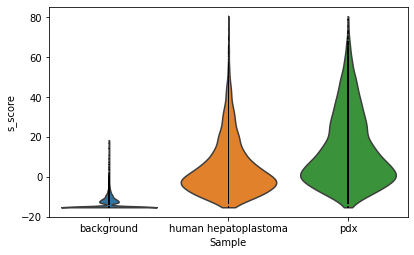

In [73]:
asc.pl.violin(adata, ['s_score'],jitter=0, multi_panel=True, groupby="Sample")

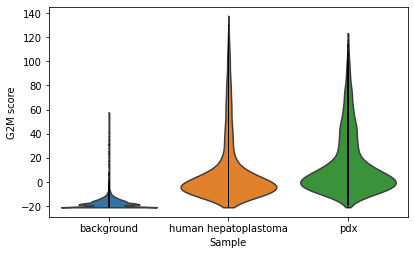

In [78]:
adata = scoring(adata, g2m_genes, "Sample", "G2M score")

### 3. select 3 cell types

In [79]:
np.unique(adata.obs["Cell class_v2"])

array(['background-B cells', 'background-Cholangiocytes',
       'background-Endothelial cells',
       'background-Hepatic Stellate cells', 'background-Hepatocytes',
       'background-Kupffer cells', 'background-NK cells',
       'background-T cells', 'human hepatoplastoma-Endothelial cells',
       'human hepatoplastoma-Hepatic Stellate cells',
       'human hepatoplastoma-Inflammatory Monocytes',
       'human hepatoplastoma-NK.T cells',
       'human hepatoplastoma-Tumor cells', 'pdx-Tumor cells'],
      dtype=object)

In [80]:
adata_3types = adata[adata.obs["Cell class_v2"].isin(["background-Hepatocytes","human hepatoplastoma-Tumor cells","pdx-Tumor cells"]),:]

In [81]:
adata_3types.shape

(21631, 33538)

In [83]:
adata_3types.obs.head(2)

,n_genes,n_counts,percent_mito,S_score,G2M_score,phase,Sample,Cell class,Cell class_v2,Tumor Cluster,count by Sample/Cell class/Tumor Cluster,tumorCluster,Sample_v2,s_score,G2M score
new_index,,,,,,,,,,,,,,,
AAACCCACAACTGAAA-HBB,2058,8974,0.207488,-0.529314,-0.381604,G1,background,Hepatocytes,background-Hepatocytes,nan,6359,nan,HBB,-9.493890,-11.011980
AAACCCAGTACGGTTT-HBB,2180,6579,0.082687,-0.634865,-0.878748,G1,background,Hepatocytes,background-Hepatocytes,nan,6359,nan,HBB,-9.741944,-14.408025


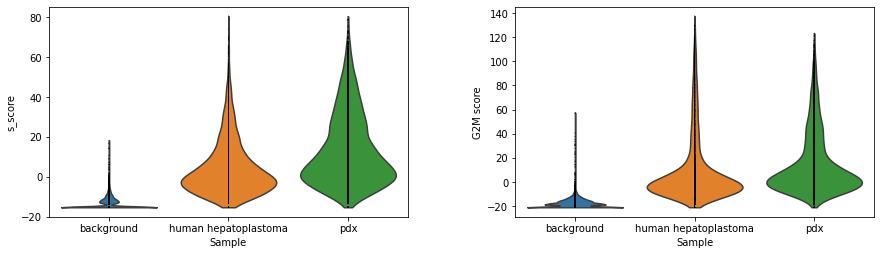

In [84]:
sc.pl.violin(adata, ['s_score',"G2M score"],jitter=0, multi_panel=True, groupby="Sample")